In [10]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
import pickle


In [11]:
import os

class Config:
    
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=512, rate=16000):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.rate = rate
        self.nfft = nfft
        self.step = int(rate/10)
        self.model_path = os.path.join('models', mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')

In [12]:
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [13]:
def build_rand_feat():
    tmp = check_data()
    
    if tmp:
        return tmp.data[0], tmp.data[1]
        
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(number_sample)):
        rand_class = np.random.choice(class_dist.index, p = prob_distribution)
        file = np.random.choice(data_frame[data_frame.corona_test == rand_class].index)
        rate, wav = wavfile.read('cleanfiles/'+file)
        label = data_frame.at[file, 'corona_test']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample, rate, numcep=config.nfeat, nfilt=config.nfilt, nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)
        y.append(classes.index(label))
    config._min = _min
    config._max = _max
    X,y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = to_categorical(y, num_classes=2)
    config.data = (X,y)
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
    return X, y

In [14]:
def get_conv_model():
    model = Sequential()
    
    model.add(Conv2D(16, (3,3), activation='relu', strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same',input_shape=input_shape))
    
    model.add(MaxPool2D(2,2))
    
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [15]:
def get_recurrent_model():
    model = Sequential()
    
    model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(128, return_sequences=True))
    model.add(Dropout(0.5))

    model.add(TimeDistributed(Dense(64, activation='relu')))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(TimeDistributed(Dense(16, activation='relu')))
    model.add(TimeDistributed(Dense(8, activation='relu')))
    
    model.add(Flatten())
    model.add(Dense(2, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
    
    return model

In [16]:
data_frame = pd.read_csv('dataset_minor2.csv')
data_frame.set_index('cough_filename', inplace=True)

for f in data_frame.index:
    rate, signal = wavfile.read('cleanfiles/'+f)
    data_frame.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(data_frame.corona_test))
class_dist = data_frame.groupby(['corona_test'])['length'].mean()
print(class_dist)

corona_test
negative    0.581199
positive    0.692211
Name: length, dtype: float64


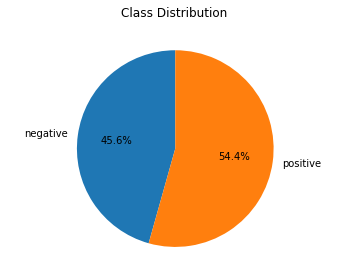

Loading existing data for conv model
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 9, 13, 16)         160       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 9, 13, 32)         4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 9, 13, 64)         18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 9, 13, 128)        73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 4, 6, 128)         0         
_________________________________________________________________
flatten_2 (Flatte

C:\Users\Deepa Kapoor\anaconda364\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1], y=[0 1 0 1 1 1 1 0 1 1 0 1 1 1 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 1 1 1
 0 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 1 0 0 1 1 0 1 0
 0 1 1 0 1 0 1 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 1 1 1 1 1 0 1 1 0 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 0
 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 1
 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1 0 1 0 0 1 1 0 0
 0 1 1 1 0 0 1 1 1 1 1 0 0 0 1 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 1 1 1
 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 1 0 1
 0 0 1 0 0 0 0 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 0 1 0
 0 1 0 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 0 0 1 0 0 1 0 0 1 1 0 1
 1 1 1 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 0 0 1 0 0 0 0

[1.15243902 0.88317757]


Epoch 1/10
22/22 [==============================] - 101s 1s/step - loss: 0.6957 - acc: 0.5062 - val_loss: 0.6828 - val_acc: 0.5658

Epoch 00001: val_acc improved from -inf to 0.56579, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 2/10
22/22 [==============================] - 2s 104ms/step - loss: 0.6844 - acc: 0.5578 - val_loss: 0.6446 - val_acc: 0.6579

Epoch 00002: val_acc improved from 0.56579 to 0.65789, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 3/10
22/22 [==============================] - 2s 83ms/step - loss: 0.6287 - acc: 0.6575 - val_loss: 0.6204 - val_acc: 0.6711

Epoch 00003: val_acc improved from 0.65789 to 0.67105, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 4/10
22/22 [==============================] - 2s 93ms/step - loss: 0.6178 - acc: 0.6721 - val_loss: 0.5860 - val_acc: 0.7368

Epoch 00004: val_acc improved from 0.67105 to 0.73684, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 5/10
22/22 [==============================] - 2s 85ms/step - loss: 0.5608 - acc: 0.6928 - val_loss: 0.5397 - val_acc: 0.7237

Epoch 00005: val_acc did not improve from 0.73684
Epoch 6/10
22/22 [==============================] - 3s 125ms/step - loss: 0.5130 - acc: 0.7693 - val_loss: 0.4869 - val_acc: 0.7500

Epoch 00006: val_acc improved from 0.73684 to 0.75000, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 7/10
22/22 [==============================] - 2s 100ms/step - loss: 0.4331 - acc: 0.8057 - val_loss: 0.4604 - val_acc: 0.7368

Epoch 00007: val_acc did not improve from 0.75000
Epoch 8/10
22/22 [==============================] - 2s 96ms/step - loss: 0.4318 - acc: 0.8087 - val_loss: 0.4621 - val_acc: 0.7500

Epoch 00008: val_acc did not improve from 0.75000
Epoch 9/10
22/22 [==============================] - 2s 109ms/step - loss: 0.4089 - acc: 0.8052 - val_loss: 0.4336 - val_acc: 0.8158

Epoch 00009: val_acc improved from 0.75000 to 0.81579, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


Epoch 10/10
22/22 [==============================] - 2s 83ms/step - loss: 0.3990 - acc: 0.8116 - val_loss: 0.4086 - val_acc: 0.8421

Epoch 00010: val_acc improved from 0.81579 to 0.84211, saving model to models\conv.model
INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


INFO:tensorflow:Assets written to: models\conv.model\assets


In [17]:
number_sample = 1 * int(data_frame['length'].sum()/0.1)
prob_distribution = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_distribution)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
#     print(X)
#     print(y)
    y_flat = np.argmax(y, axis=1)
#     print(y_flat)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
print(class_weight)
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', 
                             save_best_only=True, save_weights_only=False, period=1)

model.fit(X,y, epochs=10, batch_size=32,  shuffle=True, class_weight = None, 
          validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)

In [20]:
from sklearn.preprocessing import LabelEncoder
predicted_vector = model.predict_classes(X)
le = LabelEncoder()
yy_pred = to_categorical(le.fit_transform(predicted_vector)) 
# print(yy_pred)

Normalized confusion matrix
[[0.88 0.12]
 [0.13 0.87]]


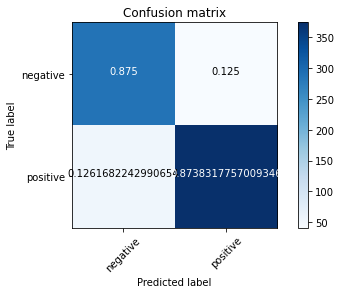

In [22]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    np.set_printoptions(precision=2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix=confusion_matrix(y.argmax(axis=1),yy_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, ['negative','positive'],
                      'Confusion matrix, without normalization')
plt.show()

In [24]:
print(classification_report(yy_pred.argmax(axis=1),y.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       341
           1       0.87      0.90      0.89       415

    accuracy                           0.87       756
   macro avg       0.87      0.87      0.87       756
weighted avg       0.87      0.87      0.87       756



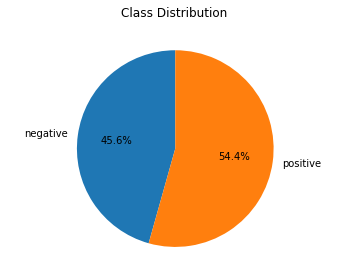

Loading existing data for time model
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_3 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_3 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 9, 16)             528       
_________________________________________________________________
time_distributed_

C:\Users\Deepa Kapoor\anaconda364\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1], y=[1 1 0 0 1 1 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1
 0 1 1 0 0 0 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 1 1 1 0 1 0 1 1 0 0 1 0 1
 0 1 1 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1
 0 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 0 0 1 0 0 1
 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 1
 0 0 0 1 1 1 1 0 1 0 0 1 0 0 1 1 0 1 0 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1
 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 0 1 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 1 1 1 1
 1 0 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1 0 0 0 1 0 0 0
 1 0 1 1 1 0 0 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1
 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 1
 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0
 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1 1

Epoch 1/10
22/22 [==============================] - 16s 128ms/step - loss: 0.6912 - acc: 0.5358 - val_loss: 0.6799 - val_acc: 0.6184

Epoch 00001: val_acc improved from -inf to 0.61842, saving model to models\time.model


INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


Epoch 2/10
22/22 [==============================] - 1s 46ms/step - loss: 0.6871 - acc: 0.5404 - val_loss: 0.6854 - val_acc: 0.6184

Epoch 00002: val_acc did not improve from 0.61842
Epoch 3/10
22/22 [==============================] - 1s 50ms/step - loss: 0.6846 - acc: 0.5516 - val_loss: 0.6734 - val_acc: 0.6711

Epoch 00003: val_acc improved from 0.61842 to 0.67105, saving model to models\time.model


INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


Epoch 4/10
22/22 [==============================] - 1s 42ms/step - loss: 0.6786 - acc: 0.5710 - val_loss: 0.6711 - val_acc: 0.6974

Epoch 00004: val_acc improved from 0.67105 to 0.69737, saving model to models\time.model


INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


Epoch 5/10
22/22 [==============================] - 1s 42ms/step - loss: 0.6751 - acc: 0.5776 - val_loss: 0.6369 - val_acc: 0.6184

Epoch 00005: val_acc did not improve from 0.69737
Epoch 6/10
22/22 [==============================] - 1s 43ms/step - loss: 0.6435 - acc: 0.6581 - val_loss: 0.6054 - val_acc: 0.7105

Epoch 00006: val_acc improved from 0.69737 to 0.71053, saving model to models\time.model


INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


Epoch 7/10
22/22 [==============================] - 1s 47ms/step - loss: 0.5970 - acc: 0.6874 - val_loss: 0.6506 - val_acc: 0.6184

Epoch 00007: val_acc did not improve from 0.71053
Epoch 8/10
22/22 [==============================] - 1s 46ms/step - loss: 0.6415 - acc: 0.5975 - val_loss: 0.5947 - val_acc: 0.7105

Epoch 00008: val_acc did not improve from 0.71053
Epoch 9/10
22/22 [==============================] - 1s 51ms/step - loss: 0.5642 - acc: 0.6960 - val_loss: 0.5916 - val_acc: 0.6711

Epoch 00009: val_acc did not improve from 0.71053
Epoch 10/10
22/22 [==============================] - 1s 46ms/step - loss: 0.6102 - acc: 0.6526 - val_loss: 0.7731 - val_acc: 0.6316

Epoch 00010: val_acc did not improve from 0.71053


INFO:tensorflow:Assets written to: models\time.model\assets


INFO:tensorflow:Assets written to: models\time.model\assets


In [25]:
number_sample = 1 * int(data_frame['length'].sum()/0.1)
prob_distribution = class_dist/class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_distribution)

fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

config = Config(mode='time')

if config.mode == 'conv':
    X, y = build_rand_feat()
#     print(X)
#     print(y)
    y_flat = np.argmax(y, axis=1)
#     print(y_flat)
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'time':
    X,y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced', np.unique(y_flat), y_flat)
print(class_weight)
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max', 
                             save_best_only=True, save_weights_only=False, period=1)

model.fit(X,y, epochs=10, batch_size=32,  shuffle=True, class_weight = None, 
          validation_split=0.1, callbacks=[checkpoint])

model.save(config.model_path)

In [26]:
from sklearn.preprocessing import LabelEncoder
predicted_vector = model.predict_classes(X)
le = LabelEncoder()
yy_pred = to_categorical(le.fit_transform(predicted_vector)) 
# print(yy_pred)

C:\Users\Deepa Kapoor\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Normalized confusion matrix
[[0.82 0.18]
 [0.45 0.55]]


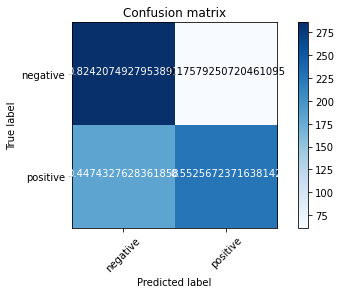

In [27]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    np.set_printoptions(precision=2)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cnf_matrix=confusion_matrix(y.argmax(axis=1),yy_pred.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(cnf_matrix, ['negative','positive'],
                      'Confusion matrix, without normalization')
plt.show()

In [28]:
print(classification_report(yy_pred.argmax(axis=1),y.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.82      0.61      0.70       469
           1       0.55      0.79      0.65       287

    accuracy                           0.68       756
   macro avg       0.69      0.70      0.68       756
weighted avg       0.72      0.68      0.68       756

